### Advanced Traffic Analysis Using Computer Vision for Strategic Business Planning

In [1]:
# Install Ultralytics library
!pip install -U ultralytics


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import cv2
from PIL import Image, ImageEnhance
from ultralytics import YOLO
from IPython.display import Video
import warnings
import optuna
import torch
from ultralytics import YOLO

warnings.filterwarnings('ignore')


In [3]:
def augment_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply augmentations
    image = cv2.flip(image, 1)  # Horizontal flip
    brightness = ImageEnhance.Brightness(Image.fromarray(image)).enhance(1.2)  # Brightness adjustment
    contrast = ImageEnhance.Contrast(brightness).enhance(1.2)  # Contrast enhancement
    
    return np.array(contrast)

In [4]:
# Configure seaborn for visualization
sns.set_theme(style="whitegrid", palette="pastel")

In [5]:
# Load YOLO model for vehicle detection and classification
yolo_model = YOLO('yolov8n.pt')

In [6]:
dataset_path = 'Vehicle_Detection_Image'
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

# Load dataset configuration
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.safe_load(file)
    print(yaml.dump(yaml_content, default_flow_style=False))

# Define image paths
train_images_path = os.path.join(dataset_path, 'train', 'images')
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# Function to analyze dataset statistics
def get_image_stats(image_path):
    count = 0
    image_sizes = set()
    for filename in os.listdir(image_path):
        if filename.endswith(('.jpg', '.png')):
            count += 1
            with Image.open(os.path.join(image_path, filename)) as img:
                image_sizes.add(img.size)
    return count, image_sizes

num_train_images, train_image_sizes = get_image_stats(train_images_path)
num_valid_images, valid_image_sizes = get_image_stats(valid_images_path)




names:
- Vehicle
nc: 1
roboflow:
  license: CC BY 4.0
  project: vehicle_detection_yolov8
  url: https://universe.roboflow.com/farzad/vehicle_detection_yolov8/dataset/3
  version: 3
  workspace: farzad
train: C:/Users/ADMIN/Jan2025/Real-Time Traffic Estimation/Vehicle_Detection_Image/train/images
val: C:/Users/ADMIN/Jan2025/Real-Time Traffic Estimation/Vehicle_Detection_Image/valid/images



In [7]:
print(f"Training Images: {num_train_images}, Unique Sizes: {train_image_sizes}")
print(f"Validation Images: {num_valid_images}, Unique Sizes: {valid_image_sizes}")

Training Images: 536, Unique Sizes: {(640, 640)}
Validation Images: 90, Unique Sizes: {(640, 640)}


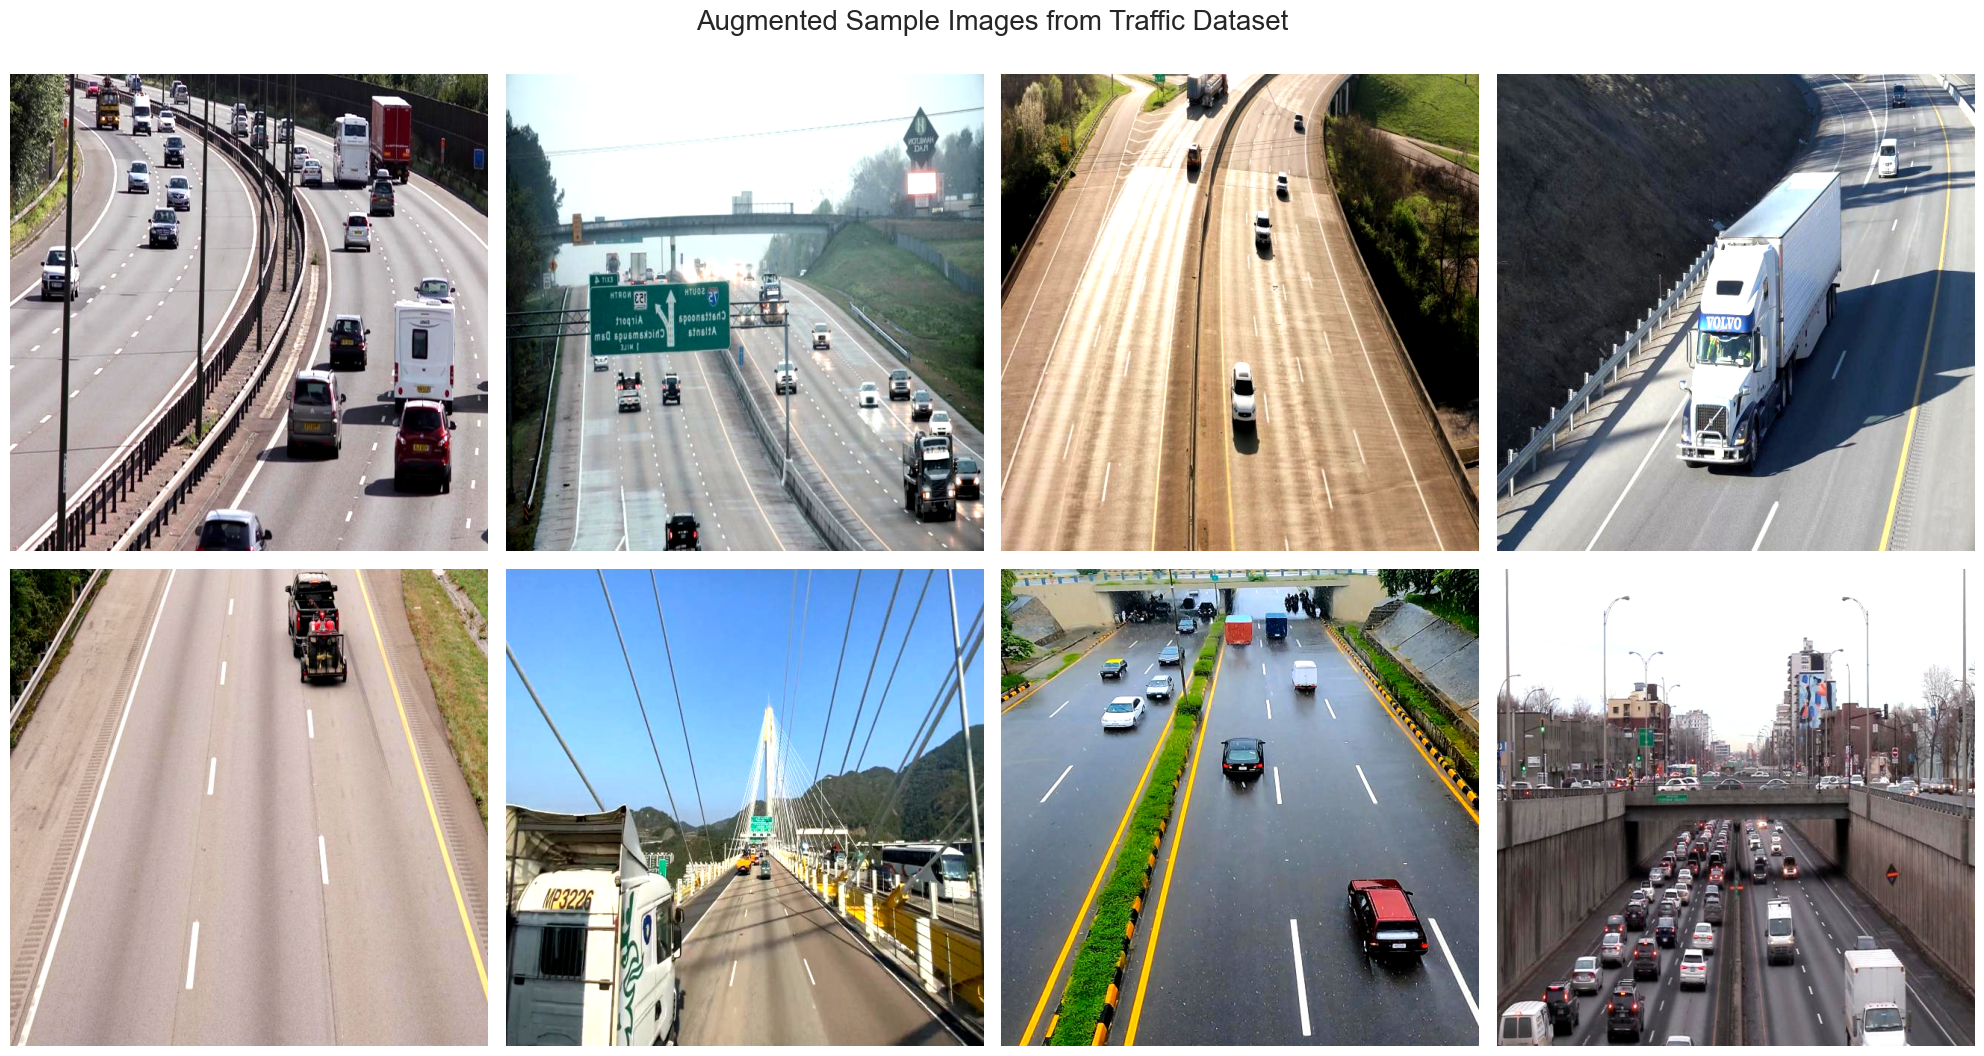

In [8]:
# Select representative images for visualization
image_files = [file for file in os.listdir(train_images_path) if file.endswith(('.jpg', '.png'))]
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, max(1, num_images // 8))][:8]

# Display selected images
fig, axes = plt.subplots(2, 4, figsize=(20, 11))
for ax, img_file in zip(axes.ravel(), selected_images):
    img_path = os.path.join(train_images_path, img_file)
    image = augment_image(img_path)
    ax.imshow(image)
    ax.axis('off')

plt.suptitle('Augmented Sample Images from Traffic Dataset', fontsize=20)
plt.tight_layout()
plt.show()



image 1/1 C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\sample_image1.jpg: 640x640 20 cars, 1 motorcycle, 192.2ms
Speed: 9.0ms preprocess, 192.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\sample_image2.jpg: 640x640 1 car, 1 truck, 133.6ms
Speed: 3.9ms preprocess, 133.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\sample_image3.jpg: 384x640 5 cars, 105.4ms
Speed: 3.6ms preprocess, 105.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\sample_image4.jpg: 640x640 (no detections), 128.9ms
Speed: 3.5ms preprocess, 128.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


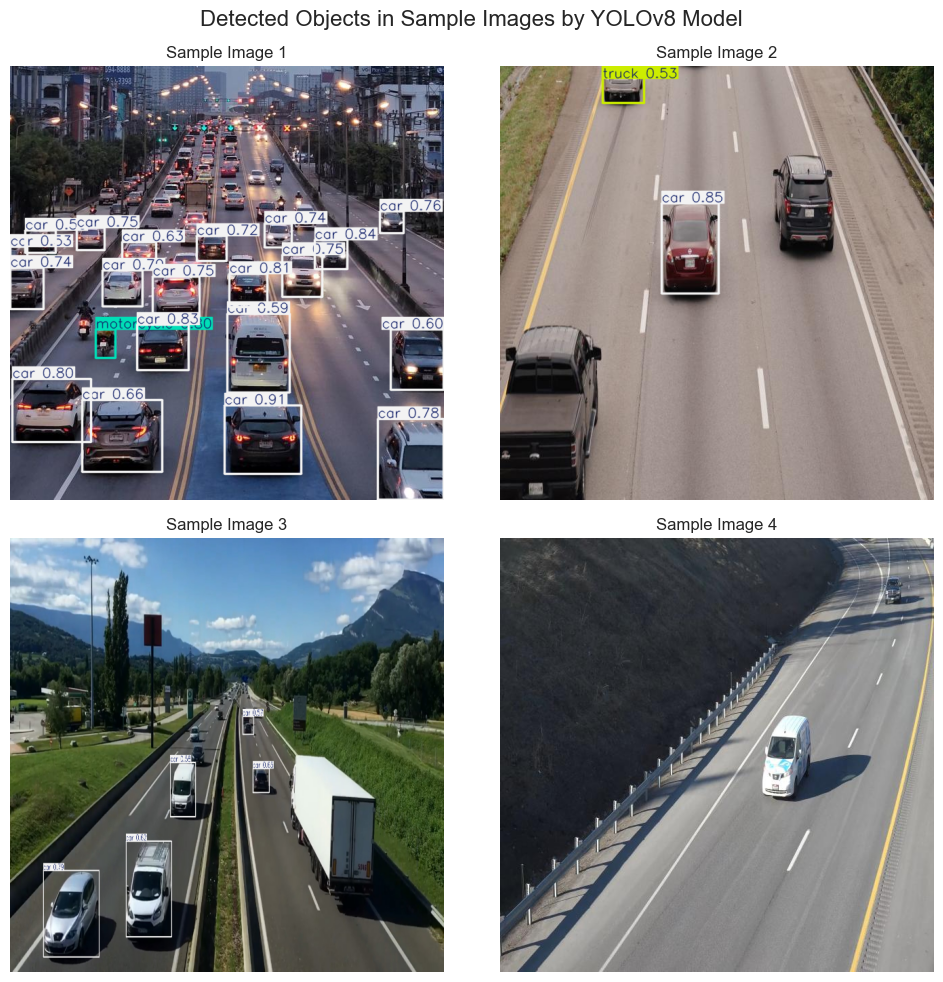

In [9]:
# View some image samples 
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, ax in enumerate(axes.ravel(), start=1):
    image_path = f'Vehicle_Detection_Image/sample_image{i}.jpg'

    if os.path.exists(image_path):
        results = yolo_model.predict(source=image_path, imgsz=(640, 640), conf=0.5)

        detected_image = results[0].plot(line_width=2)
        detected_image = cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB)

        height, width, _ = detected_image.shape

        ax.set_aspect('equal')

        target_size = (640, 640)
        resized_image = cv2.resize(detected_image, target_size)
        ax.imshow(resized_image)

        ax.set_title(f'Sample Image {i}', fontsize=12)
        ax.axis('off')
    else:
        ax.set_title(f'Image {i} not found', fontsize=12)
        ax.axis('off')

plt.suptitle('Detected Objects in Sample Images by YOLOv8 Model', fontsize=16)
plt.tight_layout()
plt.show()

In [10]:
!pip install optuna


In [12]:

# Define the objective function for hyperparameter tuning
def objective(trial):
    # Define the hyperparameters to optimize
    lr0 = trial.suggest_loguniform("lr0", 1e-5, 1e-2)
    lrf = trial.suggest_uniform("lrf", 0.01, 0.3)
    momentum = trial.suggest_uniform("momentum", 0.8, 0.98)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-2)
    dropout = trial.suggest_uniform("dropout", 0.0, 0.3)
    batch_size = trial.suggest_categorical("batch", [16, 32, 64])

    # Train the model
    results = yolo_model.train(
        data="Vehicle_Detection_Image/data.yaml",
        epochs=2,
        imgsz=640,
        device="cpu",
        batch=batch_size,
        optimizer="auto",
        lr0=lr0,
        lrf=lrf,
        momentum=momentum,
        weight_decay=weight_decay,
        dropout=dropout,
        seed=0,
        verbose=False  # Disable verbose for faster tuning
    )

    # Return the validation loss for optimization
    return results.box.maps[0]  # Mean Average Precision (mAP) at IoU=0.50


# Run hyperparameter tuning
study = optuna.create_study(direction="maximize")  # Maximize mAP
study.optimize(objective, n_trials=10)  # Run 10 trials

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2025-02-24 16:42:39,830] A new study created in memory with name: no-name-0d3dd400-111d-417f-83a1-662e6dff50e5


Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=Vehicle_Detection_Image/data.yaml, epochs=2, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=0, project=None, name=train162, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0176568618731999, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

train: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\train\labels.cache... 536 i
val: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\valid\labels.cache... 90 imag

Plotting labels to runs\detect\train162\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=1.2964335902149804e-05' and 'momentum=0.8594729930129148' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=4.166456530539682e-06), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train162
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G      1.359      1.071      1.096        137        640: 100%|██████████| 34/34 [04:04<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<0

                   all         90        937      0.829      0.469      0.618      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G      1.258     0.9249      1.054        153        640: 100%|██████████| 34/34 [04:04<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<0

                   all         90        937      0.839      0.809       0.88      0.593



2 epochs completed in 0.147 hours.
Optimizer stripped from runs\detect\train162\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train162\weights\best.pt, 6.2MB

Validating runs\detect\train162\weights\best.pt...
Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<0


                   all         90        937       0.84       0.81       0.88      0.593
Speed: 3.5ms preprocess, 119.2ms inference, 0.0ms loss, 8.9ms postprocess per image
Results saved to runs\detect\train162


[I 2025-02-24 16:51:48,077] Trial 0 finished with value: 0.5934886332082042 and parameters: {'lr0': 1.2964335902149804e-05, 'lrf': 0.285599449469921, 'momentum': 0.8594729930129148, 'weight_decay': 4.166456530539682e-06, 'dropout': 0.0176568618731999, 'batch': 16}. Best is trial 0 with value: 0.5934886332082042.


Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=Vehicle_Detection_Image/data.yaml, epochs=2, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=0, project=None, name=train1622, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1631712109541987, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tr

train: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\train\labels.cache... 536 i
val: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\valid\labels.cache... 90 imag

Plotting labels to runs\detect\train1622\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=4.765941570946979e-05' and 'momentum=0.9682273515918381' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0033091592559368146), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train1622
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G      1.205     0.8553      1.028        363        640: 100%|██████████| 17/17 [04:08<00:00, 14.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<0

                   all         90        937      0.832      0.874      0.908      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G      1.163     0.8047      1.009        409        640: 100%|██████████| 17/17 [04:08<00:00, 14.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<0

                   all         90        937      0.847      0.853      0.917      0.638



2 epochs completed in 0.149 hours.
Optimizer stripped from runs\detect\train1622\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train1622\weights\best.pt, 6.2MB

Validating runs\detect\train1622\weights\best.pt...
Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<0


                   all         90        937      0.847      0.854      0.917      0.638
Speed: 3.5ms preprocess, 123.3ms inference, 0.0ms loss, 9.4ms postprocess per image
Results saved to runs\detect\train1622


[I 2025-02-24 17:01:05,758] Trial 1 finished with value: 0.6376045453968342 and parameters: {'lr0': 4.765941570946979e-05, 'lrf': 0.16786051200762622, 'momentum': 0.9682273515918381, 'weight_decay': 0.0033091592559368146, 'dropout': 0.1631712109541987, 'batch': 32}. Best is trial 1 with value: 0.6376045453968342.


Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=Vehicle_Detection_Image/data.yaml, epochs=2, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=0, project=None, name=train16222, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.06748592637031525, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

train: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\train\labels.cache... 536 i
val: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\valid\labels.cache... 90 imag

Plotting labels to runs\detect\train16222\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=5.935240872748804e-05' and 'momentum=0.9321212364935748' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.009110745665508353), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train16222
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G      1.124      0.774     0.9946        137        640: 100%|██████████| 34/34 [03:59<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<0

                   all         90        937      0.872      0.892      0.947      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G       1.13     0.7654      0.996        153        640: 100%|██████████| 34/34 [03:59<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<0

                   all         90        937      0.863      0.873      0.919      0.635



2 epochs completed in 0.144 hours.
Optimizer stripped from runs\detect\train16222\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train16222\weights\best.pt, 6.2MB

Validating runs\detect\train16222\weights\best.pt...
Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<0


                   all         90        937      0.872      0.892      0.947      0.655
Speed: 3.4ms preprocess, 119.7ms inference, 0.0ms loss, 8.4ms postprocess per image
Results saved to runs\detect\train16222


[I 2025-02-24 17:10:03,030] Trial 2 finished with value: 0.6548386534358711 and parameters: {'lr0': 5.935240872748804e-05, 'lrf': 0.21670531246141578, 'momentum': 0.9321212364935748, 'weight_decay': 0.009110745665508353, 'dropout': 0.06748592637031525, 'batch': 16}. Best is trial 2 with value: 0.6548386534358711.


Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=Vehicle_Detection_Image/data.yaml, epochs=2, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=0, project=None, name=train162222, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.06551089934280974, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

train: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\train\labels.cache... 536 i
val: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\valid\labels.cache... 90 imag

Plotting labels to runs\detect\train162222\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0018510766792994098' and 'momentum=0.8881423584337835' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.003135468823862801), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train162222
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G       1.06     0.7243     0.9719        137        640: 100%|██████████| 34/34 [04:04<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<0

                   all         90        937      0.857      0.906      0.932      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G      1.131      0.747     0.9944        153        640: 100%|██████████| 34/34 [04:04<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<0

                   all         90        937      0.854      0.886      0.937      0.653



2 epochs completed in 0.147 hours.
Optimizer stripped from runs\detect\train162222\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train162222\weights\best.pt, 6.2MB

Validating runs\detect\train162222\weights\best.pt...
Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<0


                   all         90        937      0.854      0.886      0.937      0.653
Speed: 3.4ms preprocess, 119.9ms inference, 0.0ms loss, 7.5ms postprocess per image
Results saved to runs\detect\train162222


[I 2025-02-24 17:19:10,055] Trial 3 finished with value: 0.6530347844718448 and parameters: {'lr0': 0.0018510766792994098, 'lrf': 0.043412575980540886, 'momentum': 0.8881423584337835, 'weight_decay': 0.003135468823862801, 'dropout': 0.06551089934280974, 'batch': 16}. Best is trial 2 with value: 0.6548386534358711.


Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=Vehicle_Detection_Image/data.yaml, epochs=2, time=None, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=0, project=None, name=train1622222, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2866370950302486, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

train: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\train\labels.cache... 536 i
val: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\valid\labels.cache... 90 imag

Plotting labels to runs\detect\train1622222\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0016958312422530378' and 'momentum=0.8032654391375118' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0014502409381169934), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train1622222
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G      1.084     0.7064     0.9805        419        640: 100%|██████████| 9/9 [06:03<00:00, 40.40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<0

                   all         90        937      0.858      0.897      0.935      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G      1.102     0.6959     0.9803        475        640: 100%|██████████| 9/9 [06:52<00:00, 45.79
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<0

                   all         90        937      0.882      0.893      0.948      0.666



2 epochs completed in 0.229 hours.
Optimizer stripped from runs\detect\train1622222\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train1622222\weights\best.pt, 6.2MB

Validating runs\detect\train1622222\weights\best.pt...
Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:13<0


                   all         90        937      0.882      0.892      0.948      0.666
Speed: 3.4ms preprocess, 131.9ms inference, 0.0ms loss, 8.5ms postprocess per image
Results saved to runs\detect\train1622222


[I 2025-02-24 17:33:16,076] Trial 4 finished with value: 0.6661674160387865 and parameters: {'lr0': 0.0016958312422530378, 'lrf': 0.076268393949044, 'momentum': 0.8032654391375118, 'weight_decay': 0.0014502409381169934, 'dropout': 0.2866370950302486, 'batch': 64}. Best is trial 4 with value: 0.6661674160387865.


Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=Vehicle_Detection_Image/data.yaml, epochs=2, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=0, project=None, name=train16222222, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.018353355520724222, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

train: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\train\labels.cache... 536 i
val: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\valid\labels.cache... 90 imag

Plotting labels to runs\detect\train16222222\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0030527699161920344' and 'momentum=0.8296713837786845' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0040088828097801675), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train16222222
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G      1.032       0.67     0.9611        363        640: 100%|██████████| 17/17 [04:15<00:00, 15.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:19<0

                   all         90        937      0.835      0.899      0.929      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G      1.072     0.6859      0.973        409        640: 100%|██████████| 17/17 [04:35<00:00, 16.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<0

                   all         90        937      0.884      0.862      0.941       0.66



2 epochs completed in 0.160 hours.
Optimizer stripped from runs\detect\train16222222\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train16222222\weights\best.pt, 6.2MB

Validating runs\detect\train16222222\weights\best.pt...
Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<0


                   all         90        937      0.892      0.859      0.942       0.66
Speed: 4.2ms preprocess, 131.3ms inference, 0.0ms loss, 7.6ms postprocess per image
Results saved to runs\detect\train16222222


[I 2025-02-24 17:43:13,845] Trial 5 finished with value: 0.6601205731175586 and parameters: {'lr0': 0.0030527699161920344, 'lrf': 0.2719336702934724, 'momentum': 0.8296713837786845, 'weight_decay': 0.0040088828097801675, 'dropout': 0.018353355520724222, 'batch': 32}. Best is trial 4 with value: 0.6661674160387865.


Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=Vehicle_Detection_Image/data.yaml, epochs=2, time=None, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=0, project=None, name=train162222222, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2687913415960814, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

train: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\train\labels.cache... 536 i
val: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\valid\labels.cache... 90 imag

Plotting labels to runs\detect\train162222222\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0019371487317969675' and 'momentum=0.9342437339415941' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.004111277418974506), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train162222222
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G      1.017     0.6497     0.9579        419        640: 100%|██████████| 9/9 [06:38<00:00, 44.28
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<0

                   all         90        937      0.868      0.889       0.94      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G      1.058     0.6577     0.9652        475        640: 100%|██████████| 9/9 [05:41<00:00, 37.93
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:19<0

                   all         90        937      0.868      0.904      0.946      0.673



2 epochs completed in 0.220 hours.
Optimizer stripped from runs\detect\train162222222\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train162222222\weights\best.pt, 6.2MB

Validating runs\detect\train162222222\weights\best.pt...
Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:13<0


                   all         90        937      0.867      0.903      0.946      0.672
Speed: 4.6ms preprocess, 131.7ms inference, 0.0ms loss, 8.0ms postprocess per image
Results saved to runs\detect\train162222222


[I 2025-02-24 17:56:47,510] Trial 6 finished with value: 0.6723676278202217 and parameters: {'lr0': 0.0019371487317969675, 'lrf': 0.10507078329080516, 'momentum': 0.9342437339415941, 'weight_decay': 0.004111277418974506, 'dropout': 0.2687913415960814, 'batch': 64}. Best is trial 6 with value: 0.6723676278202217.


Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=Vehicle_Detection_Image/data.yaml, epochs=2, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=0, project=None, name=train1622222222, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.01621041687367163, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

train: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\train\labels.cache... 536 i
val: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\valid\labels.cache... 90 imag

Plotting labels to runs\detect\train1622222222\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=6.95988157236228e-05' and 'momentum=0.8718379852765923' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0021512882610607953), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train1622222222
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G     0.9596     0.6216     0.9378        137        640: 100%|██████████| 34/34 [04:25<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<0

                   all         90        937      0.872      0.919      0.941      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G      1.069      0.678     0.9689        153        640: 100%|██████████| 34/34 [04:37<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<0

                   all         90        937      0.862      0.884      0.924      0.645



2 epochs completed in 0.162 hours.
Optimizer stripped from runs\detect\train1622222222\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train1622222222\weights\best.pt, 6.2MB

Validating runs\detect\train1622222222\weights\best.pt...
Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<0


                   all         90        937      0.861      0.883      0.924      0.645
Speed: 3.5ms preprocess, 122.0ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs\detect\train1622222222


[I 2025-02-24 18:06:51,498] Trial 7 finished with value: 0.6447817258393231 and parameters: {'lr0': 6.95988157236228e-05, 'lrf': 0.11167373249428666, 'momentum': 0.8718379852765923, 'weight_decay': 0.0021512882610607953, 'dropout': 0.01621041687367163, 'batch': 16}. Best is trial 6 with value: 0.6723676278202217.


Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=Vehicle_Detection_Image/data.yaml, epochs=2, time=None, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=0, project=None, name=train16222222222, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.02294322150505329, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\train\labels.cache... 536 i
val: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\valid\labels.cache... 90 imag

Plotting labels to runs\detect\train16222222222\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=1.654853865401938e-05' and 'momentum=0.8400468895755866' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0013154967475152044), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train16222222222
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G     0.9986     0.6318     0.9522        419        640: 100%|██████████| 9/9 [06:14<00:00, 41.60
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<0

                   all         90        937      0.862        0.9       0.94       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G      1.042     0.6344     0.9592        475        640: 100%|██████████| 9/9 [06:39<00:00, 44.37
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<0

                   all         90        937      0.883      0.899      0.949      0.674



2 epochs completed in 0.229 hours.
Optimizer stripped from runs\detect\train16222222222\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train16222222222\weights\best.pt, 6.2MB

Validating runs\detect\train16222222222\weights\best.pt...
Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:13<0


                   all         90        937      0.883      0.899      0.949      0.674
Speed: 3.6ms preprocess, 129.8ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs\detect\train16222222222


[I 2025-02-24 18:20:55,791] Trial 8 finished with value: 0.674212324294577 and parameters: {'lr0': 1.654853865401938e-05, 'lrf': 0.22093814194642333, 'momentum': 0.8400468895755866, 'weight_decay': 0.0013154967475152044, 'dropout': 0.02294322150505329, 'batch': 64}. Best is trial 8 with value: 0.674212324294577.


Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=Vehicle_Detection_Image/data.yaml, epochs=2, time=None, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=0, project=None, name=train162222222222, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.06073717226207415, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

train: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\train\labels.cache... 536 i
val: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\valid\labels.cache... 90 imag

Plotting labels to runs\detect\train162222222222\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=6.423022915244597e-05' and 'momentum=0.8057968088708621' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.008302427386079336), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train162222222222
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G     0.9404     0.5888     0.9341        419        640: 100%|██████████| 9/9 [06:39<00:00, 44.42
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<0

                   all         90        937       0.89      0.888      0.952      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G      1.017     0.6149     0.9512        475        640: 100%|██████████| 9/9 [06:51<00:00, 45.69
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<0

                   all         90        937      0.874       0.91      0.943      0.666



2 epochs completed in 0.239 hours.
Optimizer stripped from runs\detect\train162222222222\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train162222222222\weights\best.pt, 6.2MB

Validating runs\detect\train162222222222\weights\best.pt...
Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:13<0


                   all         90        937       0.89      0.888      0.952      0.672
Speed: 4.0ms preprocess, 130.0ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs\detect\train162222222222


[I 2025-02-24 18:35:38,118] Trial 9 finished with value: 0.6724398386257369 and parameters: {'lr0': 6.423022915244597e-05, 'lrf': 0.29177922368447484, 'momentum': 0.8057968088708621, 'weight_decay': 0.008302427386079336, 'dropout': 0.06073717226207415, 'batch': 64}. Best is trial 8 with value: 0.674212324294577.


Best Hyperparameters: {'lr0': 1.654853865401938e-05, 'lrf': 0.22093814194642333, 'momentum': 0.8400468895755866, 'weight_decay': 0.0013154967475152044, 'dropout': 0.02294322150505329, 'batch': 64}


In [13]:

# Train final model with the best hyperparameters
results = yolo_model.train(
    data="Vehicle_Detection_Image/data.yaml",
    epochs=5,
    imgsz=640,
    device="cpu",
    **best_params
)




Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=Vehicle_Detection_Image/data.yaml, epochs=5, time=None, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=0, project=None, name=train1622222222222, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.02294322150505329, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show

train: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\train\labels.cache... 536 i
val: Scanning C:\Users\ADMIN\Jan2025\Real-Time Traffic Estimation\Vehicle_Detection_Image\valid\labels.cache... 90 imag

Plotting labels to runs\detect\train1622222222222\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=1.654853865401938e-05' and 'momentum=0.8400468895755866' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0013154967475152044), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train1622222222222
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G     0.9181     0.5715     0.9283        419        640: 100%|██████████| 9/9 [06:32<00:00, 43.62
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<0

                   all         90        937      0.893      0.882      0.945      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.017     0.6127      0.951        475        640: 100%|██████████| 9/9 [06:25<00:00, 42.85
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<0

                   all         90        937      0.887      0.908      0.952      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.087     0.6564      0.975        282        640: 100%|██████████| 9/9 [05:51<00:00, 39.01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<0

                   all         90        937      0.864      0.936      0.945      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.062     0.6429     0.9721        447        640: 100%|██████████| 9/9 [06:44<00:00, 44.93
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<0

                   all         90        937      0.863      0.916      0.946      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G       1.05     0.6342     0.9631        400        640: 100%|██████████| 9/9 [05:56<00:00, 39.58
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<0

                   all         90        937      0.887      0.912      0.957       0.69



5 epochs completed in 0.557 hours.
Optimizer stripped from runs\detect\train1622222222222\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train1622222222222\weights\best.pt, 6.2MB

Validating runs\detect\train1622222222222\weights\best.pt...
Ultralytics 8.3.78  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:13<0


                   all         90        937      0.889       0.91      0.957      0.689
Speed: 3.1ms preprocess, 129.5ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train1622222222222


## evaluation

In [ ]:
# Revised evaluation function
def evaluate_model(model, valid_path, yaml_config):
    """
    Evaluate model performance on validation set
    """
    metrics = {
        'total_images': 0,
        'detected_objects': 0,
        'confidence_scores': [],
        'class_dist': {}
    }
    
    # Get class names from YAML
    class_names = yaml_config.get('names', [])
    
    for img_file in os.listdir(valid_path):
        if img_file.endswith(('.jpg', '.png')):
            metrics['total_images'] += 1
            img_path = os.path.join(valid_path, img_file)
            
            # Run inference
            results = model.predict(img_path, imgsz=640, conf=0.5)
            
            # Process results
            for r in results:
                boxes = r.boxes
                if boxes:
                    metrics['detected_objects'] += len(boxes)
                    metrics['confidence_scores'].extend(boxes.conf.tolist())
                    
                    # Count class distribution
                    for cls in boxes.cls:
                        class_name = class_names[int(cls)]
                        metrics['class_dist'][class_name] = metrics['class_dist'].get(class_name, 0) + 1
    
    # Calculate metrics
    avg_conf = np.mean(metrics['confidence_scores']) if metrics['confidence_scores'] else 0
    detection_rate = metrics['detected_objects'] / metrics['total_images'] if metrics['total_images'] > 0 else 0
    
    # Print evaluation results
    print("\nModel Evaluation Results:")
    print(f"Total Images: {metrics['total_images']}")
    print(f"Total Detections: {metrics['detected_objects']}")
    print(f"Average Detections per Image: {detection_rate:.2f}")
    print(f"Average Confidence Score: {avg_conf:.3f}")
    print("\nClass Distribution:")
    for cls, count in metrics['class_dist'].items():
        print(f"{cls}: {count}")
    
    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(metrics['class_dist'].keys()), y=list(metrics['class_dist'].values()))
    plt.title('Class Distribution in Validation Set')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return metrics

# Run evaluation
evaluation_metrics = evaluate_model(yolo_model, valid_images_path, yaml_content)

yolo_model.export(format='onnx', imgsz=640)
results.save()